In [83]:
import pandas as pd
import psycopg2
import json
import datetime
from make_utils.db_utils import init_db
%matplotlib inline

In [84]:
pd.set_option("display.max_colwidth", 500)

In [85]:
# ssh -L 2222:localhost:5432 davidmas@lexicometer.maglo.org -N &

In [89]:
db_lexico = init_db('data/db_lexico.json')

In [90]:
channels = pd.read_sql('select * from core_channel', db_lexico)

In [6]:
channels

,id,name,publicName,programId
0,1,cnews,CNEWS,516
1,2,bfmtv,BFMTV,515
2,3,franceinfo,franceinfo,262
3,4,lci,LCI,776
4,5,france2,France 2,257
5,6,france3parisidf,France 3 Paris Ile-de-France,273
6,7,c8,C8,513
7,8,tf1,TF1,1537
8,9,lcp,LCP,1545
9,10,france4,France 4,260


In [7]:
%%time
data = pd.read_sql(f'''select channel_id, lemma, count(*) from core_word 
                       where lemma='écologie' 
                       and "dateTime" >= '2022-04-01 00:00:00' 
                       and "dateTime" <= '2022-05-24 00:00:00'
                       group by channel_id, lemma
                       ''', db_lexico)

CPU times: user 9.2 ms, sys: 7.29 ms, total: 16.5 ms
Wall time: 39 s


In [8]:
data_channel = data.merge(channels, left_on='channel_id', right_on='id')

In [9]:
data_channel

,channel_id,lemma,count,id,name,publicName,programId
0,1,écologie,1166,1,cnews,CNEWS,516
1,2,écologie,826,2,bfmtv,BFMTV,515
2,3,écologie,2001,3,franceinfo,franceinfo,262
3,4,écologie,618,4,lci,LCI,776
4,5,écologie,383,5,france2,France 2,257
5,6,écologie,237,6,france3parisidf,France 3 Paris Ile-de-France,273
6,7,écologie,66,7,c8,C8,513
7,8,écologie,114,8,tf1,TF1,1537
8,9,écologie,1689,9,lcp,LCP,1545
9,10,écologie,60,10,france4,France 4,260


# effet marc Hay on BFM

In [11]:
data = pd.read_sql(f'''select * from core_word 
                       where lemma='climatique' and channel_id=2 
                       ''', db_lexico)

In [12]:
len(data)

2382

In [13]:
data.head()

,id,dateTime,word,lemma,channel_id
0,163017216,2022-03-15 12:53:53.609870+00:00,climatique,climatique,2
1,163055901,2022-03-15 13:49:12.201623+00:00,climatique,climatique,2
2,163056860,2022-03-15 13:50:38.491382+00:00,climatique,climatique,2
3,163099285,2022-03-15 14:51:03.235437+00:00,climatique,climatique,2
4,163100202,2022-03-15 14:52:29.727479+00:00,climatique,climatique,2


In [73]:
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF8')

'fr_FR.UTF8'

<AxesSubplot:xlabel='dateTime'>

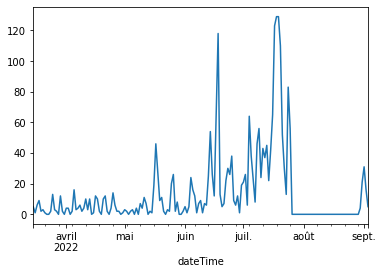

In [74]:
data.set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count().plot()

Text(0.5, 0, '')

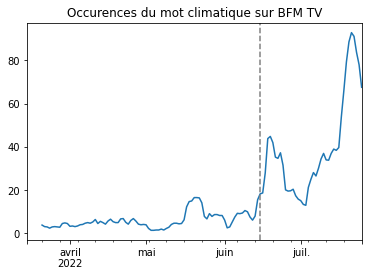

In [75]:
ax = data[data.dateTime < '2022-08-01'].set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count().rolling(7).mean().plot()
ax.axvline(x='2022-06-15', color='grey', ls='--')
ax.set_title('Occurences du mot climatique sur BFM TV')
ax.set_xlabel('')

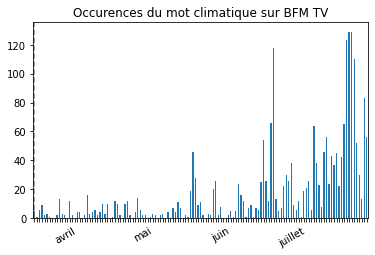

In [78]:
df = data[data.dateTime < '2022-08-01'].set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count()
ax = df.plot(kind='bar')
ax.set_title('Occurences du mot climatique sur BFM TV')
ax.set_xlabel('')

import matplotlib.ticker as mticker
ticklabels = ['']*len(df)
for k,date in enumerate(df.index):
    if date.strftime('%d') == '01':
        ticklabels[k] = date.strftime('%B')
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.figure.autofmt_xdate()

In [34]:
data2 = pd.read_sql(f'''select * from core_word 
                       where lemma='giec' and channel_id=2 
                       ''', db_lexico)

In [35]:
len(data2)

225

In [36]:
data2['dateTime'] = pd.to_datetime(data2['dateTime'])

Text(0.5, 0, '')

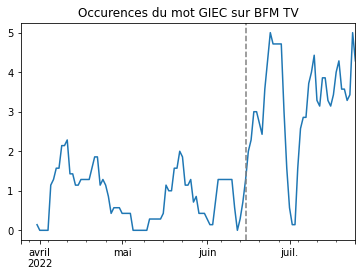

In [80]:
ax = data2[data2.dateTime < '2022-08-01'].set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count().rolling(7).mean().plot()
ax.axvline(x='2022-06-15', color='grey', ls='--')
ax.set_title('Occurences du mot GIEC sur BFM TV')
ax.set_xlabel('')

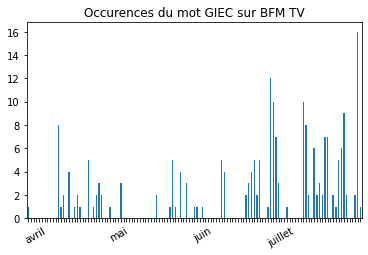

In [79]:
df = data2[data2.dateTime < '2022-08-01'].set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count()
ax = df.plot(kind='bar')
ax.set_title('Occurences du mot GIEC sur BFM TV')
ax.set_xlabel('')

import matplotlib.ticker as mticker
ticklabels = ['']*len(df)
for k,date in enumerate(df.index):
    if date.strftime('%d') == '01':
        ticklabels[k] = date.strftime('%B')
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.figure.autofmt_xdate()

# data quality

In [120]:
%% time
data = pd.read_sql(f'''select * from core_word 
                       where lemma='bonjour' and channel_id in (1, 2, 3, 4) 
                       ''', db_lexico)

In [122]:
len(data)

34075

In [123]:
data['channel'] = [channel[x] for x in data.channel_id]

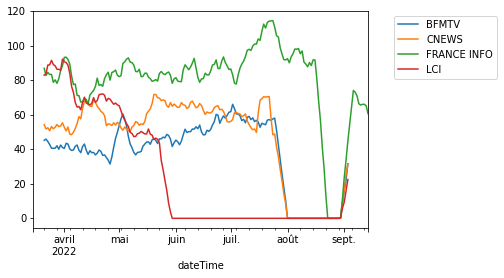

In [124]:
ax = data.groupby('channel').apply(lambda x: x.set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count().rolling(7).mean().plot(legend=True, label=x.channel.iloc[0]))
ax[0].legend(bbox_to_anchor=(1.4, 1))

# biodiversité

In [126]:
data = pd.read_sql(f'''select * from core_word 
                       where lemma='biodiversité' and channel_id in (1, 2, 3, 4) 
                       ''', db_lexico)

In [127]:
len(data)

1385

In [128]:
channel = {
    1: 'CNEWS',
    2: 'BFMTV',
    3: 'FRANCE INFO',
    4: 'LCI'
}

In [129]:
data['channel'] = [channel[x] for x in data.channel_id]

In [130]:
data.head()

,id,dateTime,word,lemma,channel_id,channel
0,165054878,2022-03-17 14:08:14.934497+00:00,biodiversité,biodiversité,2,BFMTV
1,165055046,2022-03-17 14:08:15.365787+00:00,biodiversité,biodiversité,1,CNEWS
2,165054741,2022-03-17 14:08:20.510696+00:00,biodiversité,biodiversité,4,LCI
3,165054593,2022-03-17 14:08:20.926745+00:00,biodiversité,biodiversité,3,FRANCE INFO
4,166045849,2022-03-18 07:26:44.230494+00:00,biodiversité,biodiversité,1,CNEWS


In [131]:
data_ok = data[(data.channel != 'LCI') & (data.dateTime < '2022-08-01')]

Text(0.5, 1.0, "Occurences du mot 'biodiversité'")

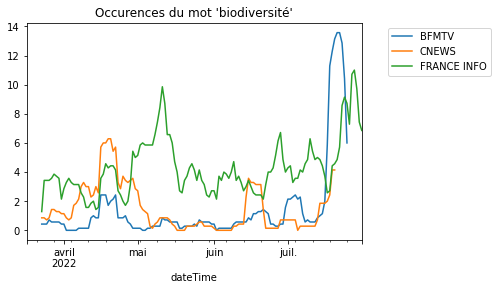

In [140]:
axs = data_ok.groupby('channel').apply(lambda x: x.set_index('dateTime').groupby(pd.Grouper(freq='1D')).word.count().rolling(7).mean().plot(legend=True, label=x.channel.iloc[0]))
ax = axs[0]
ax.legend(bbox_to_anchor=(1.4, 1))
ax.set_title("Occurences du mot 'biodiversité'")